In [164]:
from sklearn.datasets import load_iris
iris_dataset=load_iris()

In [165]:
import numpy as np
X,Y = iris_dataset.data, iris_dataset.target

# elegir eta en base a la cuota de aprendizaje?
eta=100
train_idx = np.random.randint(X.shape[0], size=eta)
X_train, Y_train = X[train_idx,:], Y[train_idx]
Y_train = np.where(Y_train < 1, -1, 1) # make label -1,1

In [166]:
# SVM
class SVM_Dual:

    def __init__(self, kernel='poly', degree=2, sigma=0.1, epoches=1000, learning_rate= 0.001):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.c = 1
        self.C = 1
        self.sigma = sigma
        self.epoches = epoches
        self.learning_rate = learning_rate

        if kernel == 'poly':
            self.kernel = self.polynomial_kernal # for polynomial kernal
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernal # for guassian

    def polynomial_kernal(self,X,Z):
        return (self.c + X.dot(Z.T))**self.degree #(c + X.y)^degree
        
    def gaussian_kernal(self, X,Z):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2) #e ^-(1/ σ2) ||X-y|| ^2
    
    def train(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0]) 

        y_mul_kernal = np.outer(y, y) * self.kernel(X, X) # yi yj K(xi, xj)

        for i in range(self.epoches):
            gradient = self.ones - y_mul_kernal.dot(self.alpha) # 1 – yk ∑ αj yj K(xj, xk)

            self.alpha += self.learning_rate * gradient # α = α + η*(1 – yk ∑ αj yj K(xj, xk)) to maximize
            self.alpha[self.alpha > self.C] = self.C # 0<α<C
            self.alpha[self.alpha < 0] = 0 # 0<α<C

            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_mul_kernal) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
            
        alpha_index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        
        # for intercept b, we will only consider α which are 0<α<C 
        b_list = []        
        for index in alpha_index:
            b_list.append(y[index] - (self.alpha * y).dot(self.kernel(X, X[index])))

        self.b = np.mean(b_list) # avgC≤αi≤0{ yi – ∑αjyj K(xj, xi) }
            
    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

In [167]:
import matplotlib.pyplot as plt
import umap

def plot_kernel(X, Y, eval_function, reducer=None, title='Plot for non linear SVM'):
    if reducer is None:
        reducer = umap.UMAP().fit(X)

    # create grid on embedded to evaluate kernel on
    maxlim, minlim = reducer.embedding_.max(axis=0), reducer.embedding_.min(axis=0)
    x0 = np.linspace(minlim[0], maxlim[0], 30)
    x1 = np.linspace(minlim[1], maxlim[1], 30)
    X1, X0 = np.meshgrid(x1, x0)
    xy_embedded = np.vstack([X0.ravel(), X1.ravel()]).T
    
    # evaluate decision function on grid points in the original space
    xy_original=reducer.inverse_transform(xy_embedded)
    Z = eval_function(xy_original)

    # create figure
    fig,ax=plt.subplots(figsize=(10,5))
    tcf=ax.contour(X0, X1, Z.reshape(X0.shape), linestyles="-", cmap='PiYG')
    #tcf=ax.tricontourf(xy_embedded[:,0], xy_embedded[:,1], Z, linestyles="-", cmap='PiYG')
    
    ax.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=Y, s=5, cmap='spring', marker='*')
    fig.colorbar(tcf)
    fig.tight_layout()
    plt.title(title)
    return fig

Accuracy:  1.0


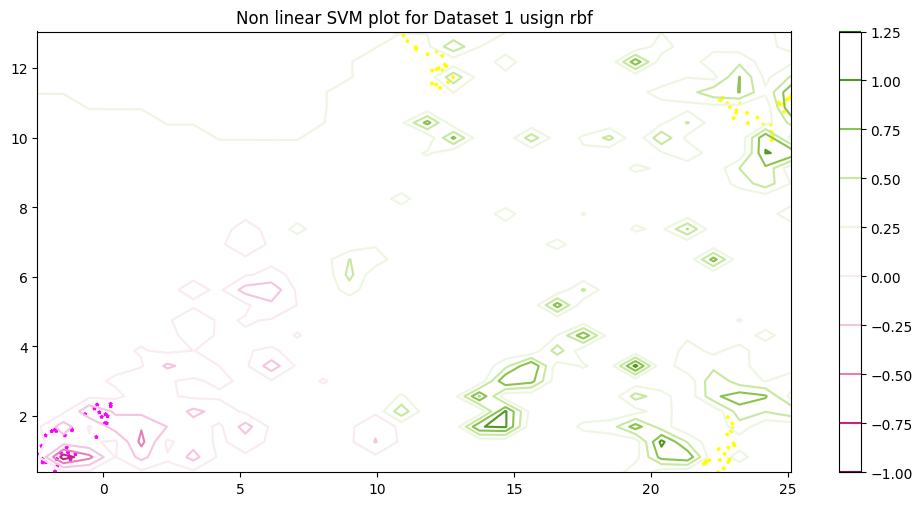

In [170]:
#X=X1; Y=y1
X=X_train; Y=Y_train

svm_dual1 = SVM_Dual(kernel = 'rbf')
svm_dual1.train(X,Y)
print("Accuracy: ", svm_dual1.score(X,Y))

#reducer = umap.UMAP().fit(X)
_=plot_kernel(X, Y, svm_dual1.decision_function, reducer=reducer, title='Non linear SVM plot for Dataset 1 usign rbf')